In [1]:
!git clone https://github.com/millermuttu/torch_soft.git
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

Cloning into 'torch_soft'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 97 (delta 23), reused 81 (delta 12), pack-reused 0
Unpacking objects: 100% (97/97), done.
     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 36.7MB 82kB/s 
     |████████████████████████████████| 952kB 24.0MB/s 
albumentations==0.5.0 is successfully installed


In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-imagenet-200/val/images/val_1598.JPEG  
  inflating: tiny-ima

In [3]:
cd '/content/torch_soft'

/content/torch_soft


In [4]:
import torch
import dataset
import models
import utils
import visual
import gradcam
import numpy as np
from torchvision import transforms
from train_test import train, test, train_ocp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.datasets as datasets
import torch.utils.data as data
from torch.utils.data import DataLoader

In [5]:
cuda, device = utils.misc.initialize_device(utils.config.SEED)
train_path = "/content/tiny-imagenet-200/train"
val_path = "/content/tiny-imagenet-200/val"

GPU Available? True


In [6]:
# setting the configs
utils.config.BATCH_SIZE = 512
utils.config.EPOCHS = 5
utils.config.NUM_WORKERS = 16

In [7]:
# normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# # [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

augmentation = transforms.RandomApply([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64)], p=.8)

training_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    augmentation,
    transforms.ToTensor()])

valid_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor()])

In [8]:
in_memory = False

In [9]:
root = '/content/tiny-imagenet-200'
training_set = dataset.TinyImageNet(root, 'train', transform=training_transform, in_memory=in_memory)
valid_set = dataset.TinyImageNet(root, 'val', transform=valid_transform, in_memory=in_memory)

In [10]:
trainloader = DataLoader(training_set, batch_size=utils.config.BATCH_SIZE, shuffle=True, num_workers=utils.config.NUM_WORKERS)
validloader = DataLoader(valid_set, batch_size=utils.config.BATCH_SIZE, num_workers=utils.config.NUM_WORKERS)

In [11]:
model = models.ResNet18(num_classes=len(training_set.label_texts)).to(device)
utils.misc.summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [12]:
# model = models.NaiveResNet(num_classes=200)
# model = model.to(device)

In [13]:
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model,lr=1E-6)

In [14]:
lr_finder = utils.lr_finder.LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.26E+01


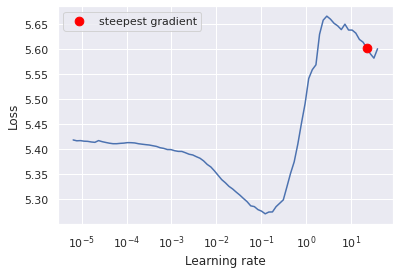

(<matplotlib.axes._subplots.AxesSubplot at 0x7f724f450208>, 22.570197196339215)

In [15]:
lr_finder.plot()

In [16]:
# reset the lr graph
lr_finder.reset()

In [ ]:
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model,lr=1)
scheduler = utils.misc.one_cycle_lr(optimizer=optimizer,max_lr=5E-1,epochs=utils.config.EPOCHS,steps_per_epoch=len(trainloader),pct_start=0.5,div_factor=10,final_div_factor=5)
# scheduler = utils.misc.ReduceLROnPlateau(optimizer=optimizer,patience=2,min_lr=1E-6,verbose=True)
# scheduler = utils.misc.StepLR_scheduler(optimizer,10)
if utils.config.DEBUG == True:
    utils.config.EPOCHS = 15

test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(utils.config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{utils.config.EPOCHS}\n")
    train_ocp(model, trainloader, optimizer,scheduler, loss_fn, device, train_losses, train_accuracy)
    # train(model, trainloader, optimizer, loss_fn, device, train_losses, train_accuracy)
    # scheduler.step()
    tl = test(model, validloader, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)
    # scheduler.step(test_loss[epoch])

  0%|          | 0/196 [00:00<?, ?it/s]

Running Epoch 1/5



Loss=4.98 Batch_ID=34 Accuracy=2.53:  18%|█▊        | 35/196 [01:26<06:16,  2.34s/it]

In [ ]:
visual.plot_metrics([{'metric':test_accuracy, 'label':'Validation Accuracy'},
                    {'metric':train_accuracy, 'label':'Training Accuracy'}], "Accuracy")